# Plant Disease Classification with CNN: Full Dataset

## 1. Create the path for all datasets
The data contains leaves images with categories are:
1. Bell Peppers 
   a. Bacterial spot with 997 images
   b. Healthy with 1478 images
2. Potatoes
   a. Early Blight with 1000 images
   b. Healthy with 152 images
   c. Late Blight with 1000 images
3. Tomatoes
   a. Target Spot with 1404 images
   b. Mosaic Virus with 373 images
   c. Yellow Leaf Curl Virus with 3209 images
   d. Bacterial Spot with 2127 images
   e. Early Blight with 1000 images
   f. Healthy with 1591 images
   g. Late Blight with 1909 images
   h. Leaf Mold with 952 images
   i. Septoria Leaf Spot with 1771 images
   j. Spider Mites with 1676  images

It means there is a imbalance dataset since one category contains 152 images, meanwhile the other contain 3209 images

In [1]:
data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage"

## 2. Load dataset into TensorFlow then split into training and validation sets

In [2]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,   # 80% train / 20% val
    subset="training",
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.


## 3. Normalize and Augmented the dataset

In [4]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),          # normalize images
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))  # just normalize val set

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

## 4. Create simple CNN model architecture

In [5]:
from tensorflow.keras import layers, models

def make_simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#num_classes = len(train_ds.class_names)
model = make_simple_cnn(IMG_SIZE + (3,), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,831 (14.14 MB)

 Trainable params: 3,706,831 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the CNN  model

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 133s 254ms/step - accuracy: 0.2652 - loss: 2.3119 - val_accuracy: 0.5941 - val_loss: 1.3001
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 106s 206ms/step - accuracy: 0.5020 - loss: 1.5212 - val_accuracy: 0.6693 - val_loss: 1.0050
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 106s 204ms/step - accuracy: 0.5542 - loss: 1.3154 - val_accuracy: 0.6901 - val_loss: 0.8751
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.5755 - loss: 1.2364 - val_accuracy: 0.7541 - val_loss: 0.7412
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 103s 199ms/step - accuracy: 0.5935 - loss: 1.1770 - val_accuracy: 0.7773 - val_loss: 0.6621
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 103s 199ms/step - accuracy: 0.6087 - loss: 1.1234 - val_accuracy: 0.7751 - val_loss: 0.6813
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 102s 198ms/step - accuracy: 0.6181 - loss: 1.0865 - val_accuracy: 0.7296 - val_loss: 0.8077
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 100s 194ms/step - accuracy: 0.6175 -

## 6. Evaluate the model

In [7]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8899 - loss: 0.3219
Validation accuracy: 0.887


## 7. Plotting the curve

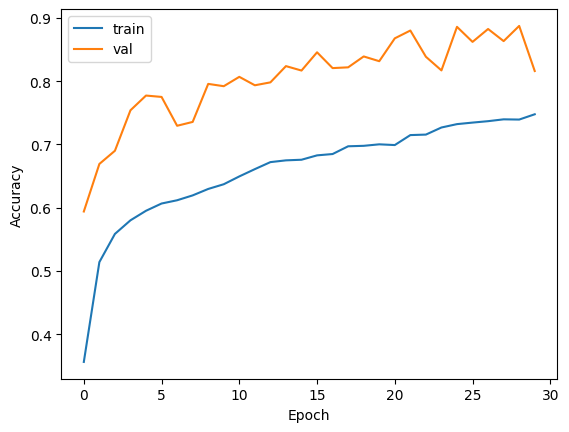

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 8. Make predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


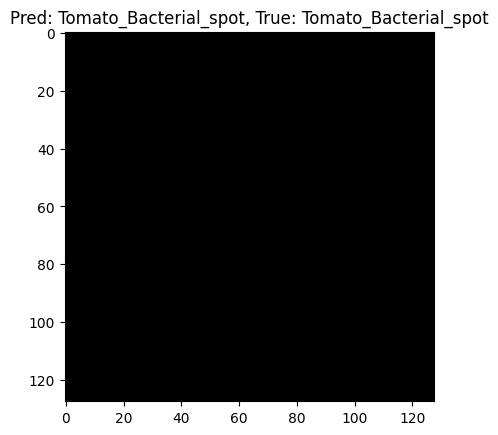

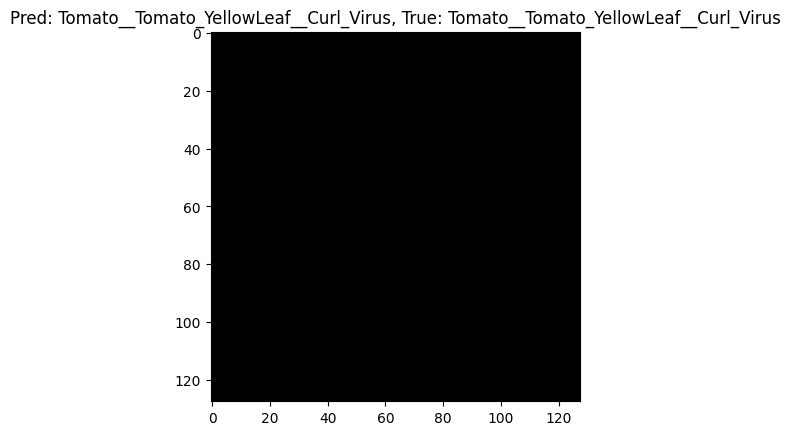

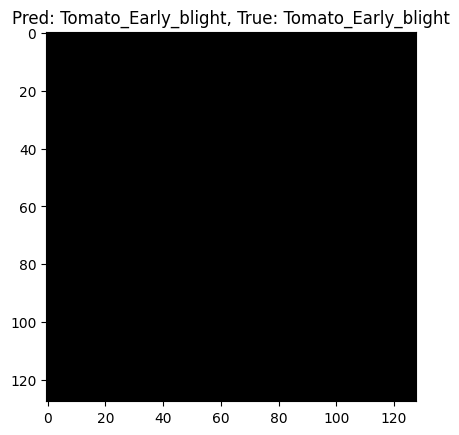

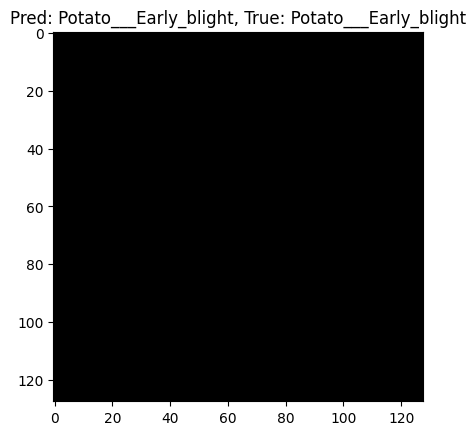

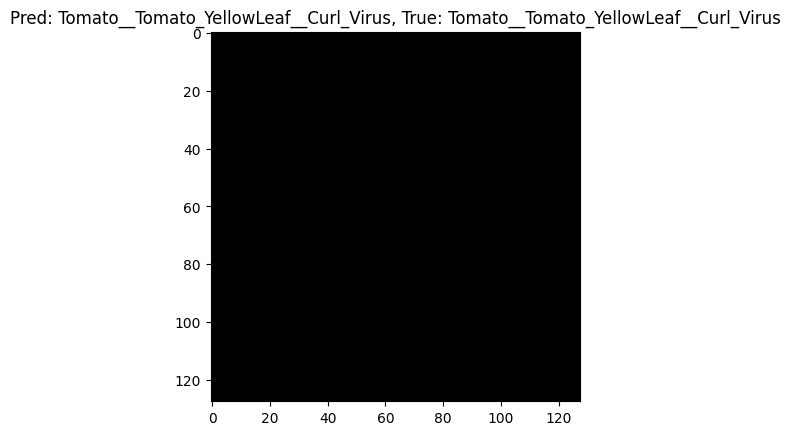

In [11]:
import numpy as np

#class_names = train_ds.class_names

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[np.argmax(preds[i])]}, True: {class_names[np.argmax(labels[i])]}")
        plt.show()

## Conclusions
1. The training accuracy is 0.740 and the validation accuracy is 0.887. It means there is underfitting. One main reason is the model couldn't predict the minority target appropriately.
2. Next attempt, the model will use balance data for all the target categories.